In [1]:
!pip install fuzzywuzzy

# Movie Production Analysis

## Business Sense

- Define the best timeline to roll out original content
    - movies profit margin per movie by release month
    - number and gross of movies per month grouped by genre
- Define the production budget and prifit margin
    - find a sweet spot that optimizes profit wrt production budget
    - look for actors and directors that make movies at the budget level

In [2]:
!ls ../zippedData/

bom.movie_gross.csv.gz
imdb.name.basics.csv.gz
imdb.title.akas.csv.gz
imdb.title.basics.csv.gz
imdb.title.crew.csv.gz
imdb.title.principals.csv.gz
imdb.title.ratings.csv.gz
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
%matplotlib inline

C:\Users\ajche\anaconda3\envs\learn-env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
mojo_df       = pd.read_csv    ('../zippedData/bom.movie_gross.csv.gz')
rt_info_df    = pd.read_csv    ('../zippedData/rt.movie_info.tsv.gz', sep='\t', encoding='iso8859_1')
rt_review_df  = pd.read_csv    ('../zippedData/rt.reviews.tsv.gz'   , sep='\t', encoding='iso8859_1')
imdb_title_df = pd.read_csv    ('../zippeddata/imdb.title.basics.csv.gz')
imdb_ratings_df = pd.read_csv  ('../zippeddata/imdb.title.ratings.csv.gz')
tmbd_df       = pd.read_csv    ('../zippedData/tmdb.movies.csv.gz'  , index_col=0)
tn_df         = pd.read_csv    ('../zippedData/tn.movie_budgets.csv.gz')

# Regarding Month to Roll out Original Material
## Using The Numbers

In [5]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


- Converting the string date to datetime64

In [6]:
tn_df.release_date = pd.DatetimeIndex(tn_df.release_date)

- Adding day, month, and year columns to the data set

In [7]:
tn_df['day_of_week']   = tn_df.release_date.dt.dayofweek
tn_df['day'] = tn_df.release_date.dt.day
tn_df['month'] = tn_df.release_date.dt.month
tn_df['year']  = tn_df.release_date.dt.year

- Find the year range of the data set.

In [8]:
tn_df.year.min(),tn_df.year.max()

(1915, 2020)

- Only look at movies that were released after 1960.

In [9]:
tn_df = tn_df[tn_df['year'] > 1960]

- Converting the grossing and budget columns to float type

In [10]:
tn_df['production_budget'] = tn_df['production_budget']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [11]:
tn_df['domestic_gross'] = tn_df['domestic_gross']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [12]:
tn_df['worldwide_gross'] = tn_df['worldwide_gross']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [13]:
tn_df = tn_df[(tn_df['production_budget'] > 0.0)]
tn_df = tn_df[tn_df['worldwide_gross'] > 0.0]
tn_df = tn_df[tn_df['domestic_gross'] > 0.0]

## - Regarding the World/Domestic Profits Relative to Month of Release

- Setting up month map for graphing

In [14]:
month_map = {0:'January',1:'Febuary',2:'March',3:'April',4:'May',5:'June',6:'July',7:'August',8:'September',9:'October',10:'November',11:'December'}
color_map = ['tab:blue','tab:blue','tab:blue','tab:blue','tab:green','tab:green','tab:green','tab:blue','tab:blue','tab:blue','tab:green','tab:green']

- Setting up varialbe sthat group by month

In [15]:
world_gross_per_movie_by_month = tn_df.groupby('month').sum()['worldwide_gross']/\
    tn_df.groupby('month').count()['movie']
domestic_gross_per_movie_by_month = tn_df.groupby('month').sum()['domestic_gross']/\
    tn_df.groupby('month').count()['movie']

<ipython-input-16-ad95186b11bf>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_ylabel('Average Net Income/Movie (in Millions)',Fontsize=16)
<ipython-input-16-ad95186b11bf>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_title('Average Income Per Movie Split by Month',Fontsize=20)
<ipython-input-16-ad95186b11bf>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(month_map.values()), rotation = 70, Fontsize=14);
<ipython-input-16-ad95186b11bf>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(list(month_map.values()), rotation = 70, Fontsize=14);


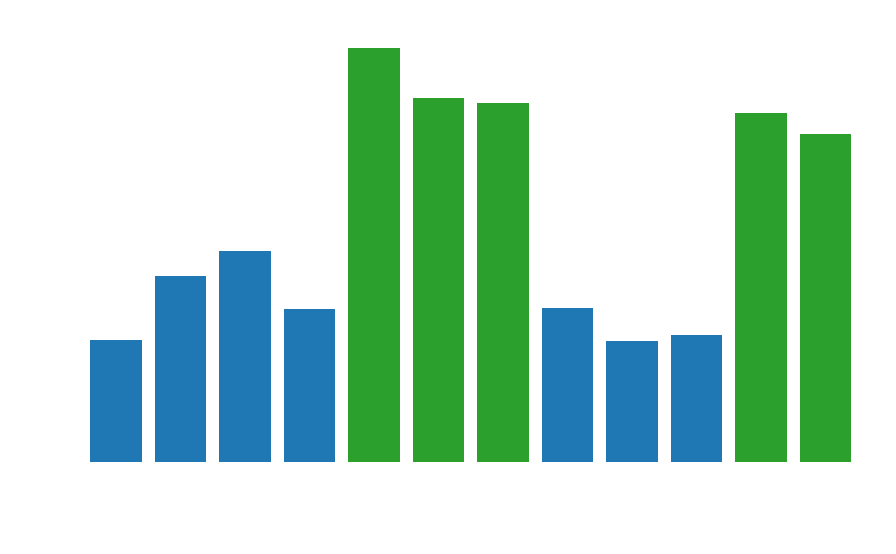

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(month_map.values(),world_gross_per_movie_by_month/1000000\
    ,color=color_map)
ax.set_ylabel('Average Net Income/Movie (in Millions)',Fontsize=16)
ax.set_title('Average Income Per Movie Split by Month',Fontsize=20)
ax.title.set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xticklabels(list(month_map.values()), rotation = 70, Fontsize=14);

fig.savefig('../images/gross_income_by_month_DARK.png', bbox_inches='tight',transparent=True)#

This plot of the net prifits of films released after 1960 shows the total net profits of movies divided by the number of movies in the month that they were released. This gives an Idea of the average net profit per movie given a specific month. Judging from this comparrison, it can be concluded that the months that generally yeild the most profit for a new release are the Summer months of May, June, July and the holliday months of November and December.

# Regarding What Genre of Movie to Release During Prime Seasons
## Using iMDB and The Numbers Datasets

In [17]:
imdb_title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


- Cleaning the iMDB Title Basic Table

- Dropping the rows with NaN values for genre

In [18]:
imdb_title_df = imdb_title_df.dropna(subset=['genres'])

### - Handling redundancies in the movie title

- Checking for redundancies in the data.

In [19]:
imdb_title_df = imdb_title_df.drop_duplicates()

- Checking for Movies with the same primary title and different release years.

In [20]:
imdb_title_df['unique_id'] = imdb_title_df['primary_title'] + '_' + imdb_title_df['start_year'].astype(str)

- Make sure there are no duplicates in the "unique_id"

In [21]:
imdb_title_df['unique_id'].value_counts()

Ângelo de Sousa - Tudo o Que Sou Capaz_2010    7
Split_2016                                     6
Inside Out_2011                                4
Maya_2015                                      4
Home_2012                                      4
                                              ..
El Nido del Trauma_2017                        1
Ad ogni costo_2010                             1
Grace Paley: Collected Shorts_2010             1
The Divide_2015                                1
Hudozhnik/TheArtist_2017                       1
Name: unique_id, Length: 138926, dtype: int64

In [22]:
imdb_title_df[imdb_title_df['unique_id'] == 'Ângelo de Sousa - Tudo o Que Sou Capaz_2010']

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,unique_id
66989,tt3815122,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66991,tt3815126,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66993,tt3815130,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66994,tt3815132,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010


- Looks like the tconst column is the only one that does not contain redundancies so we drop all but one.

In [23]:
imdb_title_df.drop_duplicates(subset=['unique_id'],inplace=True)

- Last Check

In [24]:
imdb_title_df['unique_id'].value_counts()

Swing It Kids_2015                                                         1
The Kids Across the Hill_2010                                              1
Neel Kaantha_2011                                                          1
Random Doors_2012                                                          1
The Other of Us_2013                                                       1
                                                                          ..
Tulip Fever_2017                                                           1
The Russian River: All Rivers - the Value of an American Watershed_2014    1
Herencia De Mi Padre_2013                                                  1
The Way of the Heart_2010                                                  1
Hudozhnik/TheArtist_2017                                                   1
Name: unique_id, Length: 138926, dtype: int64

- Making sure that there is a matching id key in The Numbers to join the tables.

## - Plotting the most popular movie genres in the data

In [25]:
imdb_title_df.groupby('genres').count()['tconst']

genres
Action                        2178
Action,Adult,Comedy              2
Action,Adventure               113
Action,Adventure,Animation     197
Action,Adventure,Biography      34
                              ... 
Thriller,War,Western             1
Thriller,Western                 4
War                            129
War,Western                      1
Western                        142
Name: tconst, Length: 1082, dtype: int64

- We're looking at the genres column which look like lists comma separated

In [26]:
imdb_title_df['genres'] = imdb_title_df['genres'].str.strip().str.replace(',',' ').str.split()

In [27]:
all_genres = []
for index, row in imdb_title_df.iterrows():
    all_genres.extend(row.genres)
unique_genres = set(all_genres)

- First need to separate the genres for each movie and put them into a list.

In [28]:
genres_dict = dict(zip(unique_genres,np.zeros(len(unique_genres))))

In [29]:
for index, row in imdb_title_df.iterrows():
    for genre in genres_dict:
        if genre in row.genres:
            genres_dict[genre] += 1
del genres_dict['Documentary']

- The documentary genre was among the top number of ratings , however we are justt looking at boxoffice movies so we'll nix it.
- Sort the genres dictionary by the amount of movies

In [30]:
genres_dict = {k: v for k, v in sorted(genres_dict.items(), key=lambda item: item[1],reverse=True)}

<ipython-input-31-db4e3f333b8f>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_title('Number of Movies per Genre (1960-2020)',Fontsize=20)
<ipython-input-31-db4e3f333b8f>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_ylabel('Number of Movies',Fontsize=16)
<ipython-input-31-db4e3f333b8f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(genres_dict.keys()), rotation = 70, Fontsize=14);
<ipython-input-31-db4e3f333b8f>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(list(genres_dict.keys()), rotation = 70, Fontsize=14);


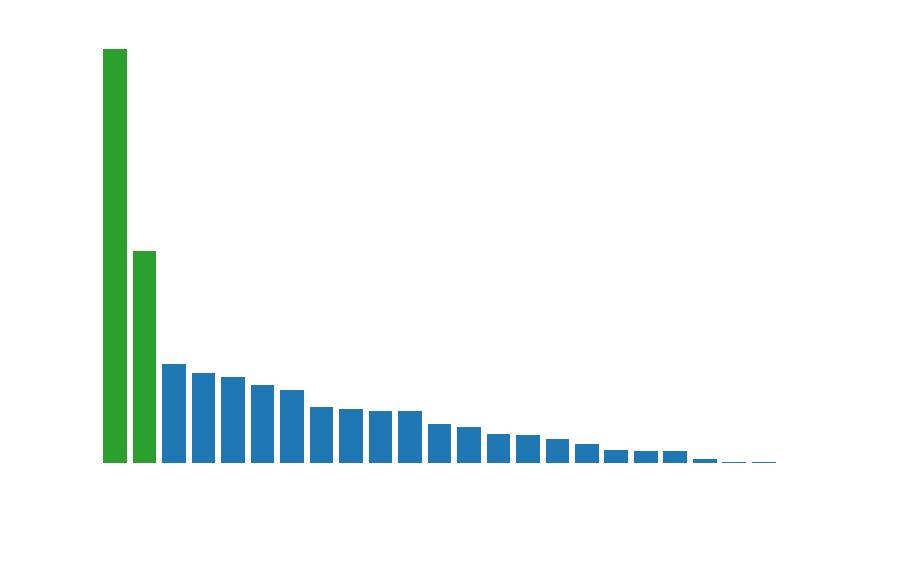

In [31]:
color_map = ['tab:green','tab:green','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue',\
    'tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue'\
        ,'tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue']
fig,ax = plt.subplots(figsize=(15,8))
ax.bar(list(genres_dict.keys()),genres_dict.values(),color=color_map)
ax.set_title('Number of Movies per Genre (1960-2020)',Fontsize=20)
ax.set_ylabel('Number of Movies',Fontsize=16)
ax.title.set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xticklabels(list(genres_dict.keys()), rotation = 70, Fontsize=14);
fig.savefig('../images/number_of_movies_by_genre_DARK.png',bbox_inches='tight',transparent=True)#

- Looks like the two most popular movie genre to make are Drama and Comedy. We might recommend doing these two assuming that the reason why they are the most popular is that they tend to do the best in the boxoffice.

- Now I wanted to look at the most popular by average rating in the iMBD data. So I need to do the same thing except tabulate the ratings this time.

- First we need to combine the ratings and basic tables from iMBD. We'll do that on the foreign key 'tconst'

In [32]:
imdb_ratings_df.tconst.value_counts()

tt2471946    1
tt3829278    1
tt2558700    1
tt2022340    1
tt2294449    1
            ..
tt5203428    1
tt3322420    1
tt2172095    1
tt3636194    1
tt5797038    1
Name: tconst, Length: 73856, dtype: int64

- Looks like no duplicates so we'll just join.

In [33]:
imbd_ratings_basic_df = imdb_title_df.set_index('tconst').join(imdb_ratings_df.set_index('tconst'),how='inner')
imbd_ratings_basic_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres,unique_id,averagerating,numvotes
tconst,,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",Sunghursh_2013,7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",One Day Before the Rainy Season_2019,7.2,43
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],The Other Side of the Wind_2018,6.9,4517
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]",Sabse Bada Sukh_2018,6.1,13
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]",The Wandering Soap Opera_2017,6.5,119


- Looks like the tables joined without a hiccup. Lets see if the data needs to be cleaned more.

In [34]:
imbd_ratings_basic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72300 entries, tt0063540 to tt9916160
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    72300 non-null  object 
 1   original_title   72300 non-null  object 
 2   start_year       72300 non-null  int64  
 3   runtime_minutes  65026 non-null  float64
 4   genres           72300 non-null  object 
 5   unique_id        72300 non-null  object 
 6   averagerating    72300 non-null  float64
 7   numvotes         72300 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.0+ MB


- Looks good, tastes great, less filling. Now to the analysis.
- First step is to reinitialize an empty genre dict to populate with empyt lists this time.

- Initialize a new genres dict but have empty lists for values.

In [35]:
genres_dict_ratings = {k: [] for k in genres_dict.keys()}
genres_dict_ratings

{'Drama': [],
 'Comedy': [],
 'Thriller': [],
 'Horror': [],
 'Action': [],
 'Romance': [],
 'Biography': [],
 'Crime': [],
 'Adventure': [],
 'History': [],
 'Family': [],
 'Mystery': [],
 'Music': [],
 'Fantasy': [],
 'Sci-Fi': [],
 'Animation': [],
 'Sport': [],
 'News': [],
 'Musical': [],
 'War': [],
 'Western': [],
 'Reality-TV': [],
 'Talk-Show': [],
 'Adult': [],
 'Short': [],
 'Game-Show': []}

- Now we need to populate the lists with average ratings.

In [36]:
for index, row in imbd_ratings_basic_df.iterrows():
    for genre in genres_dict_ratings.keys():
        if genre in row.genres:
            genres_dict_ratings[genre].append(row.averagerating/row.numvotes)
#del genres_dict_ratings['Documentary']

- now that we have a list of average ratings per genre, we can go ahead and take the average of the average.

In [37]:
ave_genres_dict_ratings = {k: np.mean(v) for k,v in genres_dict_ratings.items() if v}

- Finally need to sort the genres by average rating

In [38]:
ave_genres_dict_ratings = {k: v for k, v in sorted(ave_genres_dict_ratings.items(), key=lambda item: item[1],reverse=True)}

- Need to remove all of the show content to isolate the movie genres.

In [39]:
ave_genres_dict_ratings.keys()

dict_keys(['Short', 'Game-Show', 'Reality-TV', 'News', 'History', 'Biography', 'Music', 'Musical', 'Sport', 'Family', 'Adult', 'War', 'Western', 'Drama', 'Adventure', 'Fantasy', 'Comedy', 'Mystery', 'Animation', 'Romance', 'Sci-Fi', 'Action', 'Crime', 'Horror', 'Thriller'])

<ipython-input-40-667724b60955>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_ylabel('Number of Movies',Fontsize=16)
<ipython-input-40-667724b60955>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(ave_genres_dict_ratings.keys()), rotation = 70, Fontsize=14);
<ipython-input-40-667724b60955>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(list(ave_genres_dict_ratings.keys()), rotation = 70, Fontsize=14);


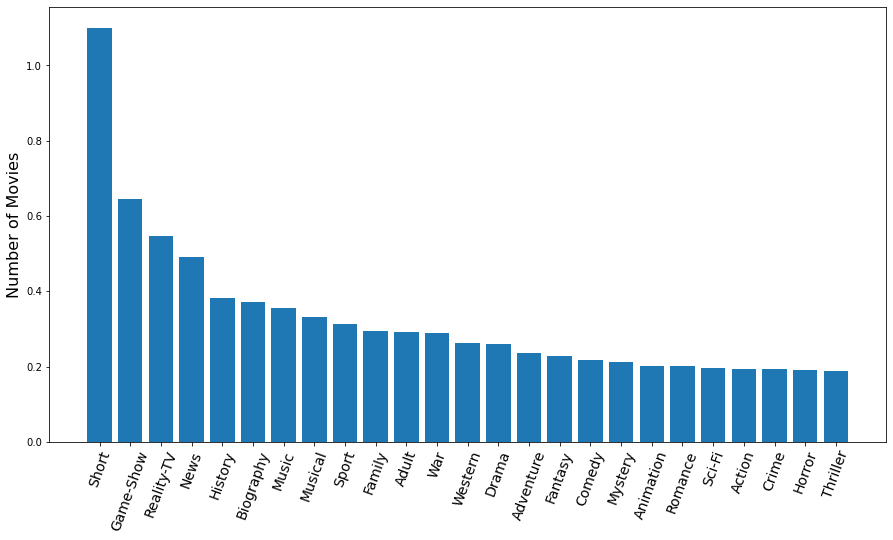

In [40]:
fig,ax = plt.subplots(figsize=(15,8))
ax.bar(ave_genres_dict_ratings.keys(),ave_genres_dict_ratings.values(),color='tab:blue')
ax.set_ylabel('Number of Movies',Fontsize=16)
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='y', colors='white')
ax.set_xticklabels(list(ave_genres_dict_ratings.keys()), rotation = 70, Fontsize=14);
fig.savefig('../images/average_rating_of_genres_DARK.png',bbox_inches='tight')#,transparent=True

# Regarding Whether to go into Foreign Markets or Stay Domestic
Looking at the trend of foreign profit margin vs. the domestic profit margin for the years between 2010 2018

In [41]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5151 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5151 non-null   int64         
 1   release_date       5151 non-null   datetime64[ns]
 2   movie              5151 non-null   object        
 3   production_budget  5151 non-null   float64       
 4   domestic_gross     5151 non-null   float64       
 5   worldwide_gross    5151 non-null   float64       
 6   day_of_week        5151 non-null   int64         
 7   day                5151 non-null   int64         
 8   month              5151 non-null   int64         
 9   year               5151 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 442.7+ KB


In [42]:
tn_df['foreign_gross'] = tn_df.worldwide_gross - tn_df.domestic_gross

In [43]:
margin_by_year = tn_df.groupby('year').sum()

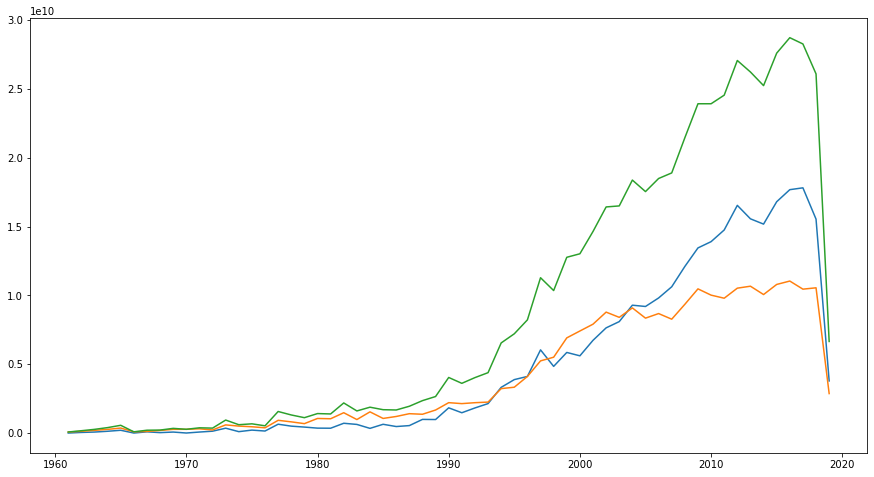

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(margin_by_year.foreign_gross)
ax.plot(margin_by_year.domestic_gross)
ax.plot(margin_by_year.worldwide_gross)

- seems like the 2018 data is incomplete likely because the data ended during that year. Removing that data.

In [45]:
tn_df = tn_df[tn_df['year'] < 2018]
tn_df['year'].max()
margin_by_year = tn_df.groupby('year').sum()

In [46]:
color_map = ['tab:green','tab:green','tab:blue','tab:blue','tab:blue','tab:blue',\
    'tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue',\
        'tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue',\
            'tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue','tab:blue',]

<ipython-input-48-e35e558da27e>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_title('Gross Income Trends from The Numbers',Fontsize=20)
<ipython-input-48-e35e558da27e>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_ylabel('Gross Income (in Billions)', Fontsize=16)
<ipython-input-48-e35e558da27e>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xlabel('Year of Release', Fontsize=16)


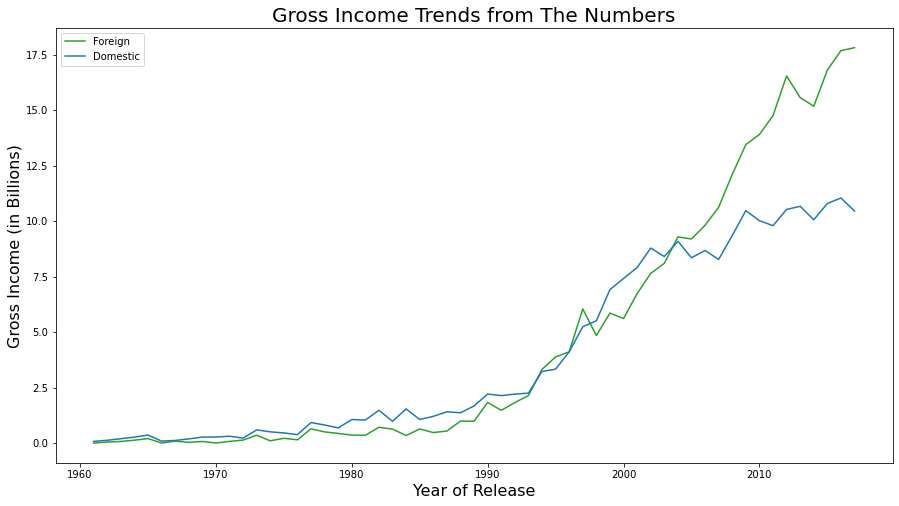

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(margin_by_year.foreign_gross/1000000000,color='tab:green')
ax.plot(margin_by_year.domestic_gross/1000000000)
ax.set_title('Gross Income Trends from The Numbers',Fontsize=20)
ax.legend(['Foreign','Domestic'])
ax.set_ylabel('Gross Income (in Billions)', Fontsize=16)
ax.set_xlabel('Year of Release', Fontsize=16)
# ax.title.set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='y', colors='white')
# ax.xaxis.label.set_color('white')
fig.savefig('../images/foreign_domestic_market_trend.png', bbox_inches='tight', transparent=True)#